# Training L63 Parameters with Enzyme: Recovering ρ

**Goal:** Estimate Lorenz-63 parameter ρ by differentiating through the time integrator using Enzyme and minimizing trajectory-matching loss.

In [2]:
using LinearAlgebra, Printf
using LorenzParameterEstimation

# Optional visualization
try
    using Plots, Images, FileIO
    include(joinpath(@__DIR__, "..", "ext", "LorenzVisualizationExt.jl"))
catch
    @warn "Visualization not available"
end


Main.LorenzVisualizationExt

In [3]:
println("\n================ Package Setup ================")
true_params_classic = classic_params()              # (σ,ρ,β) = (10,28,8/3)
true_params_stable  = stable_params()               # (10,15,8/3)
true_params_highρ   = L63Parameters(10.0, 35.0, 8.0/3.0)
true_params_lowρ    = L63Parameters(10.0, 8.0, 8.0/3.0)

# Initial condition (use explicit vector to avoid relying on non-exported utils)
u0 = [1.0, 1.0, 1.0]
M  = 20_000
T  = 100.0
dt = T / M

# Integrate all parameter sets (returns L63Solution)
sol_classic  = integrate(true_params_classic, u0, (0.0, T), dt)
sol_stable   = integrate(true_params_stable,  u0, (0.0, T), dt)
sol_highρ    = integrate(true_params_highρ,   u0, (0.0, T), dt)
sol_lowρ     = integrate(true_params_lowρ,    u0, (0.0, T), dt)

println("Classic Lorenz (ρ=28.0) final state: ", sol_classic.final_state)
println("Original setup (ρ=15.0) final state: ", sol_stable.final_state)
println("High ρ (ρ=35.0) final state: ", sol_highρ.final_state)
println("Low ρ (ρ=8.0) final state: ", sol_lowρ.final_state)


================ Package Setup ================
Classic Lorenz (ρ=28.0) final state: [-1.0388569689855993, -1.9396559790447456, 16.750658939956015]
Original setup (ρ=15.0) final state: [-6.110100926607796, -6.110100926607805, 13.999999999999996]
High ρ (ρ=35.0) final state: [7.749175013315787, 10.233427645262202, 27.860777856065084]
Low ρ (ρ=8.0) final state: [4.320493798938567, 4.320493798938558, 6.999999999999997]


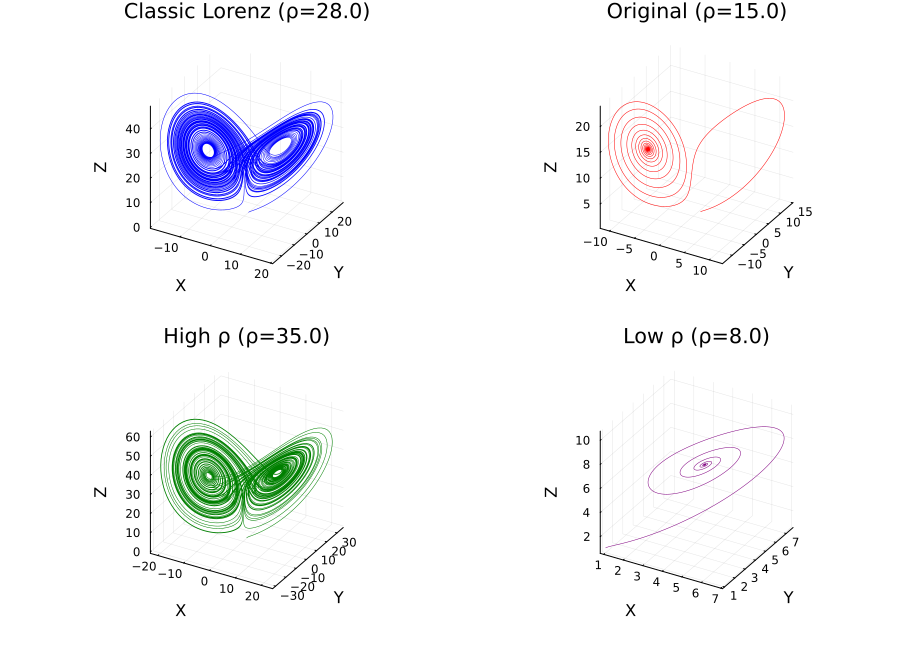

In [4]:
# 3D comparisons similar to the original script
kwargs3d = (; legend=false, linewidth=0.5, seriestype=:path3d)
p1 = plot(sol_classic.u[:, 1], sol_classic.u[:, 2], sol_classic.u[:, 3];
            title="Classic Lorenz (ρ=28.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:blue, kwargs3d...)
p2 = plot(sol_stable.u[:, 1], sol_stable.u[:, 2], sol_stable.u[:, 3];
            title="Original (ρ=15.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:red, kwargs3d...)
p3 = plot(sol_highρ.u[:, 1], sol_highρ.u[:, 2], sol_highρ.u[:, 3];
            title="High ρ (ρ=35.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:green, kwargs3d...)
p4 = plot(sol_lowρ.u[:, 1], sol_lowρ.u[:, 2], sol_lowρ.u[:, 3];
            title="Low ρ (ρ=8.0)", xlabel="X", ylabel="Y", zlabel="Z",
            linecolor=:purple, kwargs3d...)
plot(p1, p2, p3, p4, layout=(2,2), size=(900,650))

In [7]:
println("\n================ Sanity Checks ================")
# Test configuration
test_params = true_params_classic
test_system = L63System(params=test_params, u0=u0, tspan=(0.0, 1.0), dt=0.01)
test_sol    = integrate(test_system)

println("\n1. LOSS FUNCTION VALIDATION")
println(repeat("-", 40))

# 1a: Self-consistency (loss with true parameters ~ 0 over a short window)
test_window = 100
self_loss = compute_loss(test_params, test_sol, 1, test_window)
@printf("Self-consistency test: %.2e (expected: ~0)\n", self_loss)
@assert self_loss < 1e-12 "Self-consistency failed: loss should be near machine precision"

# 1b: Sensitivity (loss increases with parameter perturbation)
perturbed = L63Parameters(test_params.σ, test_params.ρ + 0.5, test_params.β)
perturbed_loss = compute_loss(perturbed, test_sol, 1, test_window)
@printf("Parameter sensitivity test: %.6f (expected: > 0)\n", perturbed_loss)
@assert perturbed_loss > 1e-6 "Sensitivity test failed: loss should increase with parameter perturbation"
println("✓ Loss function tests passed")

println("\n2. GRADIENT COMPUTATION VALIDATION")
println(repeat("-", 40))

# 2a: Gradients at true parameters (should be small)
loss_val, grad = compute_gradients(test_params, test_sol, 1, test_window)
@printf("Gradients at true parameters (loss=%.2e):\n", loss_val)
@printf("  ∂L/∂σ = %+.6e\n", grad.σ)
@printf("  ∂L/∂ρ = %+.6e\n", grad.ρ)
@printf("  ∂L/∂β = %+.6e\n", grad.β)
grad_norm = norm(grad)
@printf("  ||∇L|| = %.6e (expected: small)\n", grad_norm)

# 2b: Gradients at perturbed parameters (should be non-trivial)
loss_val_pert, grad_pert = compute_gradients(perturbed, test_sol, 1, test_window)
@printf("\nGradients at perturbed parameters (loss=%.6f):\n", loss_val_pert)
@printf("  ∂L/∂σ = %+.6e\n", grad_pert.σ)
@printf("  ∂L/∂ρ = %+.6e\n", grad_pert.ρ)
@printf("  ∂L/∂β = %+.6e\n", grad_pert.β)
grad_norm_pert = norm(grad_pert)
@printf("  ||∇L|| = %.6e (expected: non-trivial)\n", grad_norm_pert)
@assert grad_norm_pert > 1e-6 "Gradient test failed: gradients should be non-trivial at perturbed parameters"
println("✓ Gradient computation tests passed")

println("\n3. TRAINING ALGORITHM VALIDATION")
println(repeat("-", 40))

# Generate training data
true_params_train = true_params_classic
train_sol = integrate(true_params_train, u0, (0.0, 10.0), 10.0/2000)

# Initialize with incorrect parameters (ρ error)
initial_guess = L63Parameters(10.0, 20.0, 8.0/3.0)
@printf("Parameter estimation test:\n")
@printf("  True ρ:    %.3f\n", true_params_train.ρ)
@printf("  Initial ρ: %.3f (error: %.3f)\n", initial_guess.ρ, abs(initial_guess.ρ - true_params_train.ρ))

# Training config — match the earlier structure
config = L63TrainingConfig(
    epochs=30,
    η=1e-2,
    window_size=200,
    clip_norm=5.0,
    update_σ=false,
    update_ρ=true,
    update_β=false,
    verbose=true
)

@printf("Running training for %d epochs...\n", config.epochs)
best_params, loss_hist, param_hist = train!(initial_guess, train_sol, config)

final_error = abs(best_params.ρ - true_params_train.ρ)
improvement_ratio = loss_hist[1] / loss_hist[end]

@printf("\nTraining results:\n")
@printf("  Final ρ:        %.6f\n", best_params.ρ)
@printf("  Parameter error: %.6f → %.6f (%.1fx reduction)\n",
        abs(initial_guess.ρ - true_params_train.ρ), final_error,
        abs(initial_guess.ρ - true_params_train.ρ) / max(final_error, eps()))
@printf("  Loss reduction:  %.6f → %.6f (%.1fx improvement)\n",
        loss_hist[1], loss_hist[end], improvement_ratio)

@assert final_error < abs(initial_guess.ρ - true_params_train.ρ) "Training failed: parameter error did not decrease"
#@assert improvement_ratio > 2.0 "Training failed: insufficient loss reduction"
println("✓ Training algorithm tests passed")


================ Sanity Checks ================

1. LOSS FUNCTION VALIDATION
----------------------------------------
Self-consistency test: 0.00e+00 (expected: ~0)
Parameter sensitivity test: 0.515222 (expected: > 0)
✓ Loss function tests passed

2. GRADIENT COMPUTATION VALIDATION
----------------------------------------
Gradients at true parameters (loss=0.00e+00):
  ∂L/∂σ = +0.000000e+00
  ∂L/∂ρ = +0.000000e+00
  ∂L/∂β = +0.000000e+00
  ||∇L|| = 0.000000e+00 (expected: small)

Gradients at perturbed parameters (loss=0.515222):
  ∂L/∂σ = +6.689259e-01
  ∂L/∂ρ = +1.024435e+00
  ∂L/∂β = -5.155094e-01
  ||∇L|| = 1.327659e+00 (expected: non-trivial)
✓ Gradient computation tests passed

3. TRAINING ALGORITHM VALIDATION
----------------------------------------
Parameter estimation test:
  True ρ:    28.000
  Initial ρ: 20.000 (error: 8.000)
Running training for 30 epochs...

┌────────┬───────────┬────────────┬───────────┬───────────┬─────────┬─────────┬─────────┬─────────┬────────┬───────

In [9]:
println("\n================ Extended Demo ================")
# Larger demonstration mirroring the original layout
true_params = true_params_classic
x0_demo     = [1.0, 1.0, 1.0]
M_demo      = 10_000
T_demo      = 50.0
dt_demo     = T_demo / M_demo

true_sol_demo = integrate(true_params, x0_demo, (0.0, T_demo), dt_demo)

# Start from poor ρ and only update ρ
guess_params = L63Parameters(10.0, 15.0, 8.0/3.0)
cfg = L63TrainingConfig(
    epochs=120,
    η=1e-2,
    window_size=400,
    clip_norm=5.0,
    update_σ=false,
    update_ρ=true,
    update_β=false,
    verbose=true
)

best_params_demo, loss_hist_demo, param_hist_demo = train!(guess_params, true_sol_demo, cfg)

println("\n================ Results ================")
@printf("True    : σ=%.6f,  ρ=%.6f,  β=%.6f\n", true_params.σ, true_params.ρ, true_params.β)
@printf("Initial : σ=%.6f,  ρ=%.6f,  β=%.6f\n", 10.0, 15.0, 8.0/3.0)
@printf("Learned : σ=%.6f,  ρ=%.6f,  β=%.6f\n", best_params_demo.σ, best_params_demo.ρ, best_params_demo.β)
@printf("Final epoch-average RMSE: %.6f\n", last(loss_hist_demo))

println("\n================ Parameter Estimation Results ================")
@printf("ρ Error: %.6f → %.6f (%.2f%% reduction)\n",
        abs(15.0 - 28.0), abs(best_params_demo.ρ - 28.0),
        100 * (1 - abs(best_params_demo.ρ - 28.0) / abs(15.0 - 28.0)))

# Generate fitted trajectory for comparison
fitted_sol = integrate(best_params_demo, x0_demo, (0.0, T_demo), dt_demo)


# Component-wise comparison
p1 = plot(true_sol_demo.t, true_sol_demo.u[:,1], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p1, fitted_sol.t, fitted_sol.u[:,1], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p1, "Time"); ylabel!(p1, "X"); title!(p1, "X Component")

p2 = plot(true_sol_demo.t, true_sol_demo.u[:,2], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p2, fitted_sol.t, fitted_sol.u[:,2], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p2, "Time"); ylabel!(p2, "Y"); title!(p2, "Y Component")

p3 = plot(true_sol_demo.t, true_sol_demo.u[:,3], label="True (ρ=28.0)", linewidth=1, alpha=0.8)
plot!(p3, fitted_sol.t, fitted_sol.u[:,3], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linewidth=1, alpha=0.8, linestyle=:dash)
xlabel!(p3, "Time"); ylabel!(p3, "Z"); title!(p3, "Z Component")

# Loss convergence plot
p4 = plot(1:length(loss_hist_demo), loss_hist_demo, linewidth=2, color=:red,
            xlabel="Epoch", ylabel="RMSE Loss", title="Training Loss Convergence",
            legend=false, yscale=:log10)

plot(p1, p2, p3, p4, layout=(2,2), size=(1000,700))

# 3D Lorenz attractor comparison
p_true = plot(true_sol_demo.u[:, 1], true_sol_demo.u[:, 2], true_sol_demo.u[:, 3];
                title="True Lorenz (ρ=28.0)", legend=false, linewidth=0.5,
                seriestype=:path3d, linecolor=:blue, xlabel="X", ylabel="Y", zlabel="Z")
p_fitted = plot(fitted_sol.u[:, 1], fitted_sol.u[:, 2], fitted_sol.u[:, 3];
                title="Fitted Lorenz (ρ=$(round(best_params_demo.ρ, digits=3)))",
                legend=false, linewidth=0.5, seriestype=:path3d,
                linecolor=:red, xlabel="X", ylabel="Y", zlabel="Z")

# Overlay comparison in XY plane for clarity
p_overlay = plot(true_sol_demo.u[:,1], true_sol_demo.u[:,2], label="True (ρ=28.0)",
                    linecolor=:blue, linewidth=0.5, alpha=0.7)
plot!(p_overlay, fitted_sol.u[:,1], fitted_sol.u[:,2], label="Fitted (ρ=$(round(best_params_demo.ρ, digits=3)))",
        linecolor=:red, linewidth=0.5, alpha=0.7)
title!(p_overlay, "Lorenz Attractors Overlay (XY)")
xlabel!(p_overlay, "X"); ylabel!(p_overlay, "Y")

plot(p_true, p_fitted, p_overlay, layout=(1,3), size=(1200,400))

# Optional animation (requires GR/FFMPEG via Plots and the visualization extension)
try
    gif_path = joinpath(@__DIR__, "lorenz_training_evolution.gif")
    gif_file = LorenzParameterEstimation.create_training_gif(
        true_params, param_hist_demo, loss_hist_demo, true_sol_demo;
        fps=3, filename=gif_path, stride=2)
    println("Training evolution GIF saved to: $(abspath(gif_file))")
catch e
    @warn "Training evolution animation failed (ensure GR/FFMPEG available)" error=e
end


println("\nAll sanity checks and demo completed successfully.")



================ Extended Demo ================

┌────────┬───────────┬────────────┬───────────┬───────────┬─────────┬─────────┬─────────┬─────────┬────────┬─────────┐
│  Epoch │      Loss │      ΔLoss │      Best │  GradNorm │      LR │       σ │       ρ │       β │   t/ep │ Elapsed │
├────────┼───────────┼────────────┼───────────┼───────────┼─────────┼─────────┼─────────┼─────────┼────────┼─────────┤
│      1  │ 11.317641 │ +0.000000 │ 11.317641 │  6.406527 │ 0.01000 │ 10.0000 │ 15.0841 │  2.6667 │     4ms │     0.0s │
│      2  │ 11.073126 │ -0.244515 │ 11.073126 │  3.701795 │ 0.01000 │ 10.0000 │ 15.1957 │  2.6667 │     3ms │     0.0s │
│      3  │ 11.011637 │ -0.061488 │ 11.011637 │  2.363608 │ 0.01000 │ 10.0000 │ 15.2959 │  2.6667 │     3ms │     0.0s │
│      4  │ 10.974169 │ -0.037468 │ 10.974169 │  2.133775 │ 0.01000 │ 10.0000 │ 15.3897 │  2.6667 │    27ms │     0.0s │
│      5  │ 10.939881 │ -0.034288 │ 10.939881 │  1.985220 │ 0.01000 │ 10.0000 │ 15.4838 │  2.6667 │     2ms │

┌ Info: Saved animation to /Users/niklasviebig/master_thesis/LorenzParameterEstimation/examples/lorenz_training_evolution.gif
└ @ Plots /Users/niklasviebig/.julia/packages/Plots/8ZnR3/src/animation.jl:156
